In [26]:
import pandas as pd
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt

sns.set(rc={'figure.figsize':(10, 8)})

In [2]:
df = pd.read_csv('train_music.csv', sep =',')
df

,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3,service_8_count_m3,income_brnd_cont_m3,data_type_1_m3,data_type_2_m3,data_type_3_m3,service_9_flag_m3
0,48104912810,0,7,1514,3,1.0,0,0.496508,0,299.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,13762.315646,1292.468784,NaN
1,4851497268,0,4,896,28,1.0,0,0.881540,0,189.0,...,11.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.000053,NaN
2,4877823097,0,7,592,3,2.0,0,0.811192,0,347.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.000977,NaN
3,4830183791,0,7,1756,3,2.0,0,0.928449,1,343.0,...,66.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.006680,NaN
4,48103940036,0,4,1057,28,1.0,0,0.578654,0,355.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.002487,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,4819141039,0,7,812,3,2.0,0,0.963514,0,357.0,...,65.0,0.0,0.0,0.0,0.0,NaN,NaN,815.758405,54.737625,NaN
69996,4888452526,0,7,1057,3,1.0,1,0.777850,0,364.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
69997,4812460312,0,7,745,3,2.0,0,0.980984,0,363.0,...,54.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
69998,4890036665,0,7,56,3,1.0,0,0.770969,0,341.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1832.938670,72.373650,NaN


In [3]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 461 entries, id to service_9_flag_m3
dtypes: float64(452), int64(9)
memory usage: 246.2 MB


In [4]:
df_new = df.sample(n = 20000, random_state=42)
df_new

,id,target,device_type,manufacturer_category,os_category,sim_count,tp_flag,lt,block_flag,days_exp,...,service_5_count_m3,service_6_count_m3,service_7_cost_m3,service_7_flag_m3,service_8_count_m3,income_brnd_cont_m3,data_type_1_m3,data_type_2_m3,data_type_3_m3,service_9_flag_m3
46730,48101197942,0,7,592,3,2.0,0,0.632435,0,108.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,716.420311,NaN,NaN
48393,48104251257,0,7,1057,3,2.0,0,0.540345,0,330.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,80.144736,14.630618,NaN
41416,4811813104,0,7,1057,3,2.0,0,0.951582,0,344.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.018959,0.000977,57.100249,NaN
34506,48101053138,0,7,745,3,2.0,0,0.659047,0,361.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
43725,4830019330,0,7,1057,3,2.0,0,0.926471,0,199.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1989.913944,29.685412,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63473,4894477348,1,7,1057,3,2.0,0,0.707827,0,221.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
66494,4875984633,0,7,592,3,2.0,0,0.824135,0,355.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,5979.779220,265.482364,NaN
56986,4811247711,0,7,728,3,1.0,0,0.924764,0,208.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
43542,4896164388,0,7,1057,3,2.0,0,0.716732,0,324.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,28.008975,10.813313,NaN


In [6]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 46730 to 59369
Columns: 461 entries, id to service_9_flag_m3
dtypes: float64(452), int64(9)
memory usage: 70.5 MB


In [8]:
df_new.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
id,20000.0,1.306414e+10,1.719221e+10,4.825674e+08,4.832647e+09,4.872661e+09,4.897139e+09,4.810855e+10
target,20000.0,7.480000e-02,2.630749e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
device_type,20000.0,6.529000e+00,1.201970e+00,1.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00
manufacturer_category,20000.0,8.895698e+02,4.940030e+02,1.000000e+00,5.920000e+02,8.960000e+02,1.057000e+03,1.836000e+03
os_category,20000.0,7.733400e+00,9.564214e+00,1.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,2.800000e+01
...,...,...,...,...,...,...,...,...
income_brnd_cont_m3,2654.0,1.789848e+01,7.412896e+01,7.843000e-01,2.745100e+00,8.329400e+00,1.950978e+01,3.001067e+03
data_type_1_m3,2359.0,2.319182e+03,5.695641e+03,1.325607e-04,5.390087e+01,4.940910e+02,2.052402e+03,7.218172e+04
data_type_2_m3,12782.0,2.796011e+03,6.620885e+03,4.959106e-05,1.303041e+02,6.685948e+02,2.463017e+03,2.751830e+05
data_type_3_m3,14299.0,3.689081e+02,1.061644e+03,3.051758e-05,4.845811e+00,5.673287e+01,3.009783e+02,3.355381e+04


In [24]:
s = df_new.isna().sum()
nan = pd.DataFrame(data = s[s != 0].sort_values(ascending=False), columns=['Total NaN count'])
nan['Percent'] = df_new.isna().mean() * 100.0

nan.T

,count_url_category_13,count_url_category_15,count_app_3,vol_app_3,count_url_category_12,count_app_11,vol_app_11,count_url_category_1,count_gift_type_4,rr_gift_type_4,...,act_days_count_m2,paym_el_count_m2,paym_el_sum_m2,short_in_calls_part_m2,short_out_calls_part_m2,paym_el_count_m1,sms_onnet_out_pack_count_m2,sms_onnet_out_pack_count_m1,service_5_count_m2,abon_part_m2
Total NaN count,19853.000,19760.0,19719.000,19719.000,19644.00,19546.00,19546.00,19450.00,19425.000,19425.000,...,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000
Percent,99.265,98.8,98.595,98.595,98.22,97.73,97.73,97.25,97.125,97.125,...,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015


Ситуация с null ужасна, перед тем как делать окончательные выводы, посмотрим что у нас с балансом.

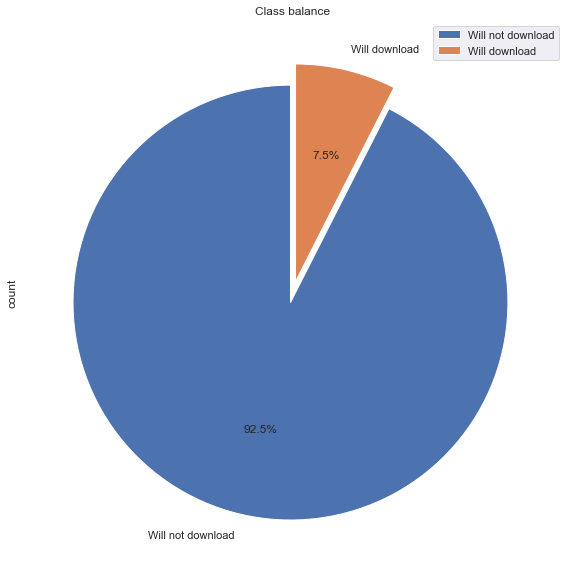

In [23]:
figure, ax = plt.subplots(figsize=(10, 10))

ax.set_title("Class balance")

pd.DataFrame(
    {'count': [df_new['target'].isin([0]).sum(),
               df_new['target'].isin([1]).sum()]},
    index=['Will not download','Will download']
).plot.pie(subplots=True, figsize=(8, 8), autopct='%1.1f%%', shadow=False, startangle=90, explode=(0.05, 0.05), ax=ax)

plt.show()

На первый взгляд всё плохо. Огромное количество пропущенных данных и плохой баланс.
Очевидно, что семантику данных восстановить не получится, поскольку это данные пользователей и они как-то обработаны.
Прийдется работать с тем, что есть

Для анализа пропущенных значений я попробую использовать - missingo
Он позволяет наглядно построить графики пропущенных значений

D:\anaconda3\lib\site-packages\missingno\missingno.py:60: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


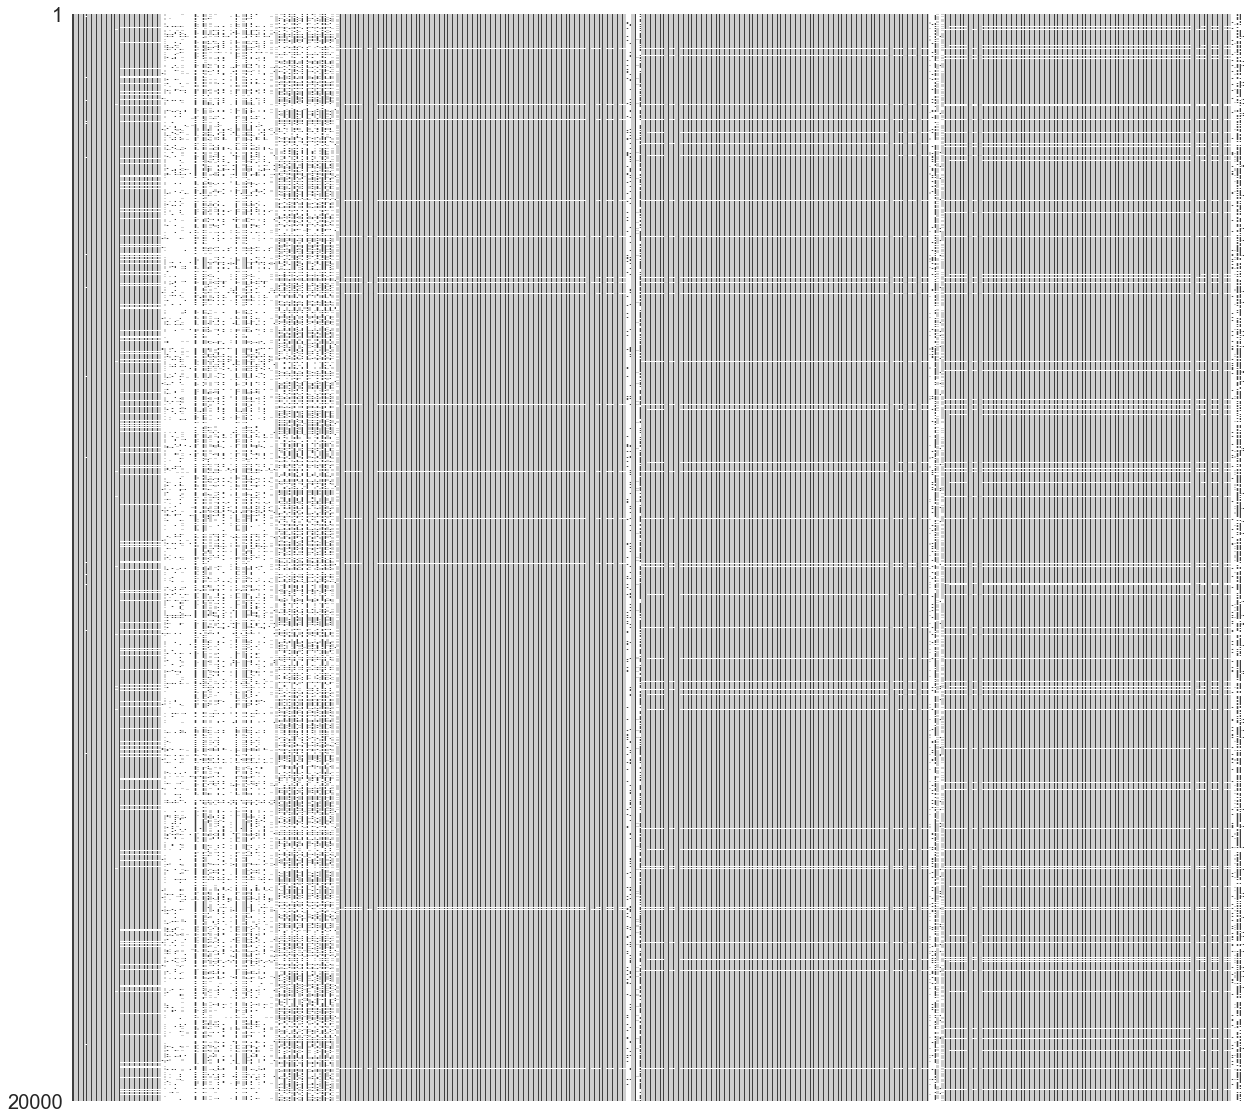

In [29]:
# figure, ax = plt.subplots(figsize=(21, 20))
#
# msno.matrix(df_new, ax=ax)
# plt.show()

In [30]:
limitPer = len(df_new) * .25
df_new = df_new.dropna(thresh=limitPer, axis=1)

In [31]:
s = df_new.isna().sum()
nan = pd.DataFrame(data = s[s != 0].sort_values(ascending=False), columns=['Total NaN count'])
nan['Percent'] = df_new.isna().mean() * 100.0

nan.T

,count_app_12,vol_app_12,count_act_type_3,rr_act_type_3,count_app_10,vol_app_10,rr_act_type_2,count_act_type_2,rr_act_type_5,count_act_type_5,...,service_6_count_m1,paym_el_count_m2,paym_el_sum_m1,sms_onnet_out_pack_count_m2,sms_omo_out_pack_count_m2,paym_el_count_m1,abon_part_m2,service_5_count_m2,service_6_count_m2,act_days_count_m1
Total NaN count,14905.000,14905.000,13641.000,13641.000,13308.00,13308.00,13172.00,13172.00,12682.00,12682.00,...,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000,3.000
Percent,74.525,74.525,68.205,68.205,66.54,66.54,65.86,65.86,63.41,63.41,...,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015,0.015


In [32]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 46730 to 59369
Columns: 418 entries, id to data_type_3_m3
dtypes: float64(409), int64(9)
memory usage: 63.9 MB
